# Amazon Reviews for SA fine-grained 5 clases CSV


In [31]:
import seaborn as sb
import matplotlib.pyplot as plt
from time import perf_counter
import math

import numpy as np
import pandas as pd
import re
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from textblob import TextBlob
from tqdm import tqdm

pd.options.mode.chained_assignment = None
from wordcloud import WordCloud

plt.rcParams.update(plt.rcParamsDefault)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/beatrizag__/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Dataset


In [32]:
train_df = pd.read_csv('../docs/train.csv').dropna()
test_df = pd.read_csv('../docs/test.csv').dropna()

In [33]:
# Shorten the number of samples from every class_index type (n = 5000)

classes = []
n_samples = 5000

for i in range(1, 6):
    classes.append(train_df.query(f'class_index == {i}').sample(n=n_samples))

train_df_s = pd.concat(classes)
train_df_s.reset_index(drop=True, inplace=True)


train_df_s['review_full']= train_df_s['review_title'] + ' ' + train_df_s['review_text']



## Exploratory analysis


In [34]:
# checking for presence of null values that might interfere with data processing
train_df.isna().sum()

class_index     0
review_title    0
review_text     0
dtype: int64

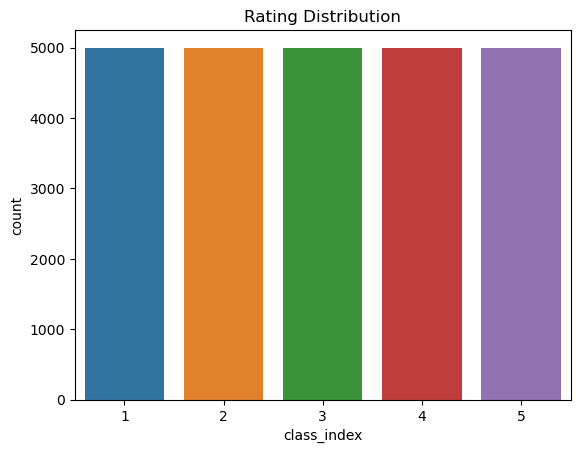

In [35]:
sb.countplot(x='class_index', data=train_df_s)
plt.title('Rating Distribution')
plt.show()

### Word distribution

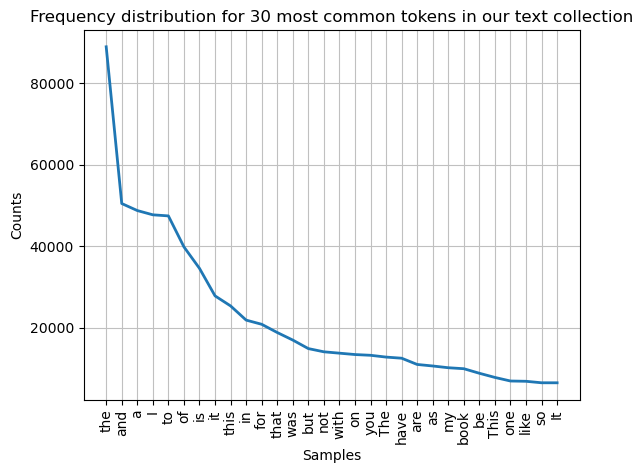

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection'}, xlabel='Samples', ylabel='Counts'>

In [36]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([ w for w in c.split()])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection')


In [37]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([w for w in train_df_s['review_full']])
tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names())
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
idf = pd.DataFrame({'feature_name':cv.get_feature_names(), 'idf_weights':tfidf_transformer.idf_}).sort_values('idf_weights')
idf

,feature_name,idf_weights
50246,the,1.102427
3265,and,1.216009
50998,to,1.278274
50513,this,1.313984
26821,it,1.325382
...,...,...
15656,dovey,10.433524
15658,dowager,10.433524
15659,dowd,10.433524
15660,dowdle,10.433524


### Sentiment analysis

In [38]:
def sentiment_analysis(string):
    sentences = TextBlob(string).sentences
    sentiments = [s.sentiment.polarity for s in sentences]
    return sum(sentiments)/len(sentiments)

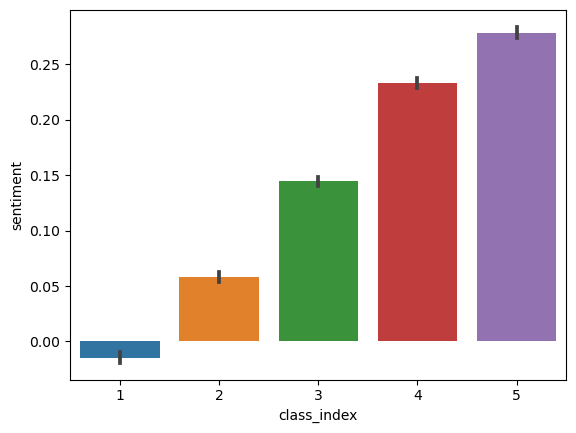

In [39]:
train_df_s['sentiment'] = train_df_s['review_title'] 
train_df_s['weight'] = train_df_s['review_title'] 

for i, review_full in enumerate(train_df_s['review_full']):
    sentiment = sentiment_analysis(review_full)
    train_df_s['sentiment'][i] = sentiment
    train_df_s['weight'][i] = 1 - abs(((sentiment + 1) / 2) - (train_df_s['class_index'][i] / 5))

sb.barplot(data=train_df_s, x='class_index', y='sentiment')
plt.show()



## Preprocess data


In [40]:
stop_words = list(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('no')
stop_words.extend(['book','movie','product','one','time','cd','dvd'])

words = list(nltk.corpus.words.words())
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def handle_negation(string_array):
    string = ''
    i = 0
    while(i < (len(string_array) - 1)):
      if (string_array[i] == 'not'):
        string = string + ' ' + 'NOT_' + string_array[i + 1] 
        i += 1
      else:
        string = string + ' ' + string_array[i]
      i += 1
    return string

def preprocess_data(string):
    string = string.lower()
    text_contractions = [contractions.fix(w) for w in string.split()]
    string = re.sub("[^a-zA-Z]", " ", " ".join(text_contractions))
    string_list = word_tokenize(string)
    text_stems = [stemmer.stem(w) for w in string_list if w not in stop_words]
    return handle_negation(text_stems)

In [41]:
for i, review_full in tqdm(enumerate(train_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    train_df_s['review_full'][i] = preprocess_text

train_df_s.head()

25000it [00:34, 731.67it/s]


,class_index,review_title,review_text,review_full,sentiment,weight
0,1,Bad CD quality,I got the CDs with a little delay. Some of the...,bad qualiti got cd littl delay cd play well o...,-0.01875,0.709375
1,1,Didn't Work,I was disappointed with the quality of this it...,NOT_work disappoint qualiti item sent defect ...,-0.2,0.8
2,1,Back to the drawing board with this one.,"While $2.00 is not a lot of money, this poorly...",back draw board NOT_lot money poorli produc s...,0.153704,0.623148
3,1,Good Marketing Job,"Good marketing, Good product positioning, Good...",good market job good market good posit good l...,0.394,0.503
4,1,I cant believe this!! DOES NOT WORK,I was thinking about buying this toy for a lon...,NOT_believ NOT_work think buy toy long tri ex...,0.125,0.6375


### Word distribution after preprocessing

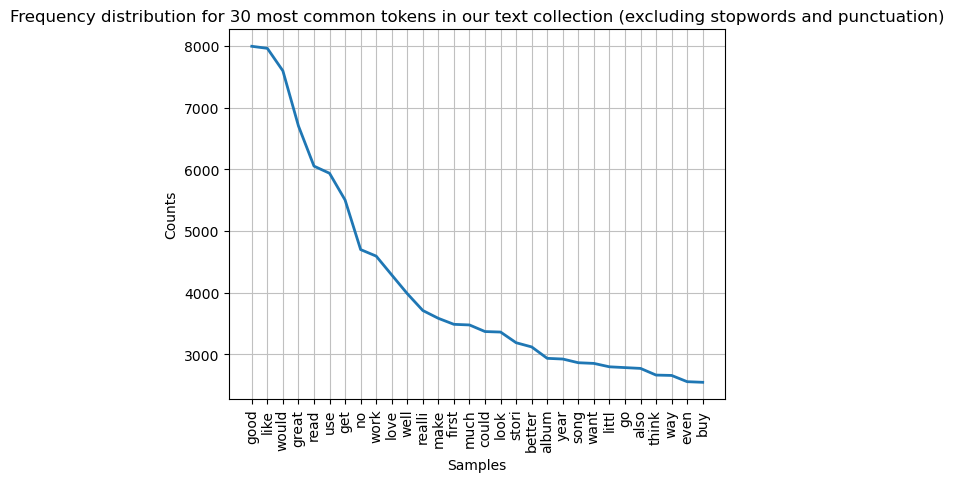

<AxesSubplot:title={'center':'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [42]:
c = " ".join([w for w in train_df_s['review_full']])

fdist_filtered = FreqDist([ w for w in c.split()])
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')


In [43]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform([w for w in train_df_s['review_full']])
tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names())
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
idf = pd.DataFrame({'feature_name':cv.get_feature_names(), 'idf_weights':tfidf_transformer.idf_}).sort_values('idf_weights')
idf

,feature_name,idf_weights
18994,like,2.408825
13645,good,2.424992
40877,would,2.433342
13919,great,2.591245
13264,get,2.716173
...,...,...
18215,kubitschek,10.433524
18214,kubert,10.433524
18213,kubelik,10.433524
18248,kutubu,10.433524


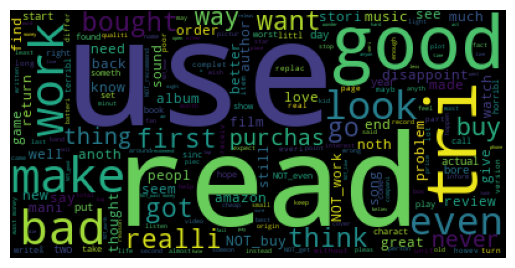

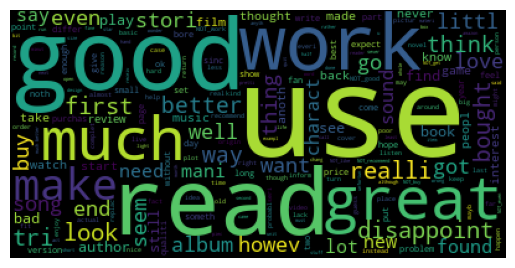

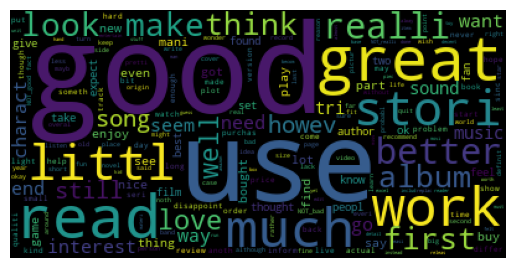

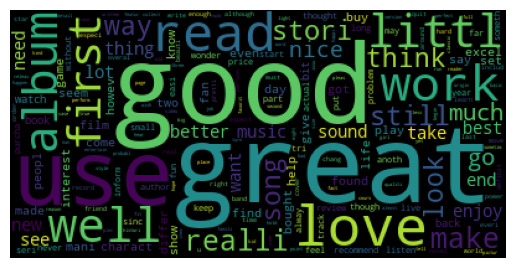

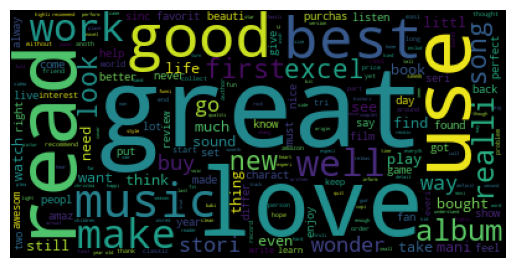

In [44]:
for i in range(1,6):
  wordcloud = WordCloud().generate(" ".join(train_df_s['review_full'][j] for j in range(0, train_df_s['review_full'].shape[0]) if train_df_s['class_index'][j] == i ))
  plt.figure()
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

## Machine Learning

### Transform train dataset

In [45]:
corpus = train_df_s['review_full']

vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

X = Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).fit_transform(corpus)

y = train_df_s['class_index']



### Transform test dataset

In [46]:
n_samples = 5000

test_df_s = test_df.sample(n=n_samples)
test_df_s.reset_index(drop=True, inplace=True)

test_df_s['review_full']= test_df_s['review_title'] + ' ' + test_df_s['review_text']


for i, review_full in tqdm(enumerate(test_df_s['review_full'])):
    preprocess_text = preprocess_data(review_full)
    test_df_s['review_full'][i] = preprocess_text

corpus = test_df_s['review_full']

X_test =  Pipeline([
    ('count_vectorizer', vectorizer),
    ('tfidf_transformer', tfidf)
]).transform(corpus)

y_test = test_df_s['class_index']



5000it [00:06, 776.55it/s]


In [47]:
test_df_s

,class_index,review_title,review_text,review_full
0,2,What a Headache,We were told to get this system by a doctor. T...,headach told get system doctor work fine husb...
1,3,Dirk Pitt Revealed: Why is this not in Audio b...,Dirk Pitt Revealed: Why is this not in Audio b...,dirk pitt reveal NOT_audio form dirk pitt rev...
2,5,Great,The book itself is beautiful. It's an easy rea...,great beauti easi read simpl love stori compl...
3,4,"Good, but not the definitive version!",I like this version of Pride & Prejudice and l...,good NOT_definit version like version pride p...
4,3,"Well, its ok",Take into account everything that has been wri...,well ok take account everyth written sucker t...
...,...,...,...,...
4995,5,Role players fantasy,This was a great book. I read it several times...,role player fantasi great read sever time fir...
4996,4,Fast read and marvellous book,Murder Most Puzzling is both a fast read--coul...,fast read marvel murder puzzl fast read could...
4997,5,Great Product,Although we don't have HD reciever for our sat...,great although NOT_hd reciev satellit system ...
4998,4,Yummy!,This just happens to be my favourite BFTE (Bef...,yummi happen favourit bfte fumbl toward ecsta...


### Model and training 


In [48]:
accuracy = []
f1 = []
recall = []
precision = []
times_fit = []
times_predict = []

algorithms = ['Naive Bayes', 'Decision Tree', 'Neural Networks', 'Suport Vector Machine', 'K-nearest Neighbors', 'Logistic Regression']

def algorithm_analysis(y_pred, y_test):
  accuracy.append(accuracy_score(y_test, y_pred))
  f1.append(f1_score(y_test, y_pred,  average='macro'))
  recall.append(recall_score(y_test, y_pred, average='macro'))
  precision.append(precision_score(y_test, y_pred, average='macro'))

  table_data={
      'Accuracy': accuracy[-1],
      'Precision': precision[-1],
      'F1 score': f1[-1],
      'Recall score': recall[-1]}

  return pd.DataFrame([table_data]).style.hide_index()

#### Naive Bayes


In [49]:
et = perf_counter()
mnb_model = MultinomialNB().fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = mnb_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_mnb = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.445000,0.445997,0.445107,0.445359


#### Decision Tree


In [50]:
et = perf_counter()
dtc_model = DecisionTreeClassifier().fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = dtc_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_dct = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.336200,0.334584,0.335419,0.336570


#### Neural Networks


In [51]:
et = perf_counter()
nn_model = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500,activation = 'relu',solver='adam',random_state=1).fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = nn_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_nn = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.407600,0.409682,0.408496,0.407845


#### Suport Vector Machine

In [52]:
et = perf_counter()
sgdc_model = SVC(decision_function_shape='ovo').fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = sgdc_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_sgdc = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


Accuracy,Precision,F1 score,Recall score
0.478600,0.478558,0.478683,0.479110


#### K Nearest Neighbors

In [53]:
et = perf_counter()
knc_model = KNeighborsClassifier(n_neighbors=50).fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = knc_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_knc = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)

Accuracy,Precision,F1 score,Recall score
0.370000,0.363416,0.364326,0.370570


#### Logistic Regression

In [54]:
et = perf_counter()
lr_model = LogisticRegression().fit(X, y)
st = perf_counter()
times_fit.append((st-et))

et = perf_counter()
y_pred = lr_model.predict(X_test)
st = perf_counter()
times_predict.append((st-et))

confusion_matrix_lr = confusion_matrix(y_test, y_pred)
algorithm_analysis(y_pred, y_test)


/Users/beatrizag__/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy,Precision,F1 score,Recall score
0.477000,0.472302,0.474415,0.477545


# Results

/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_34963/4231153974.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels([0,1,2,3,4,5])
/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_34963/4231153974.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels([0,1,2,3,4,5])


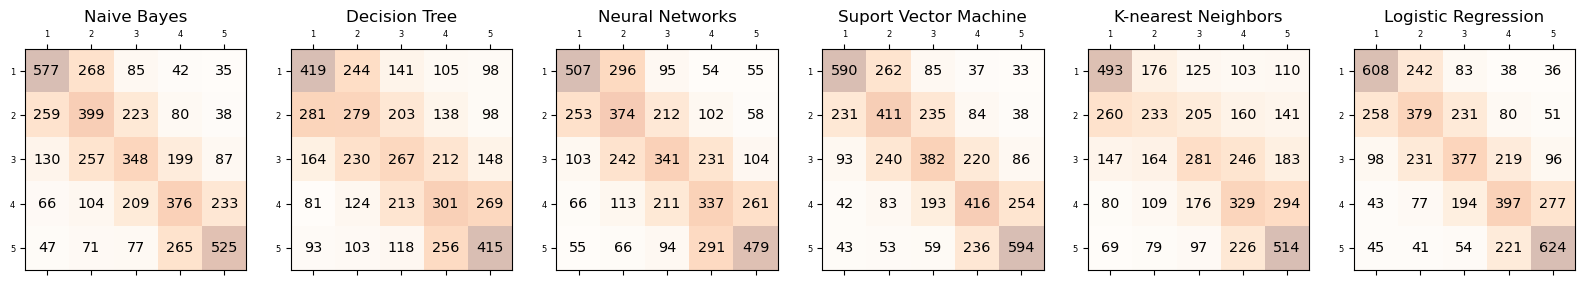

In [55]:
plt.rcParams['font.size'] = '6'

fig, axs = plt.subplots(1, 6, figsize=(20,5))
matrixes = [confusion_matrix_mnb, confusion_matrix_dct, confusion_matrix_nn, confusion_matrix_sgdc, confusion_matrix_knc, confusion_matrix_lr]
for index, ax in enumerate(axs):
  ax.matshow(matrixes[index], cmap=plt.cm.Oranges, alpha=0.3)
  for i in range(matrixes[index].shape[0]):
      for j in range(matrixes[index].shape[1]):
          ax.text(x=j, y=i,s=matrixes[index][i, j], va='center', ha='center', size='xx-large')
  ax.set_title(algorithms[index], fontsize= '12')
  ax.xaxis.set_ticklabels([0,1,2,3,4,5])
  ax.yaxis.set_ticklabels([0,1,2,3,4,5])


plt.show()

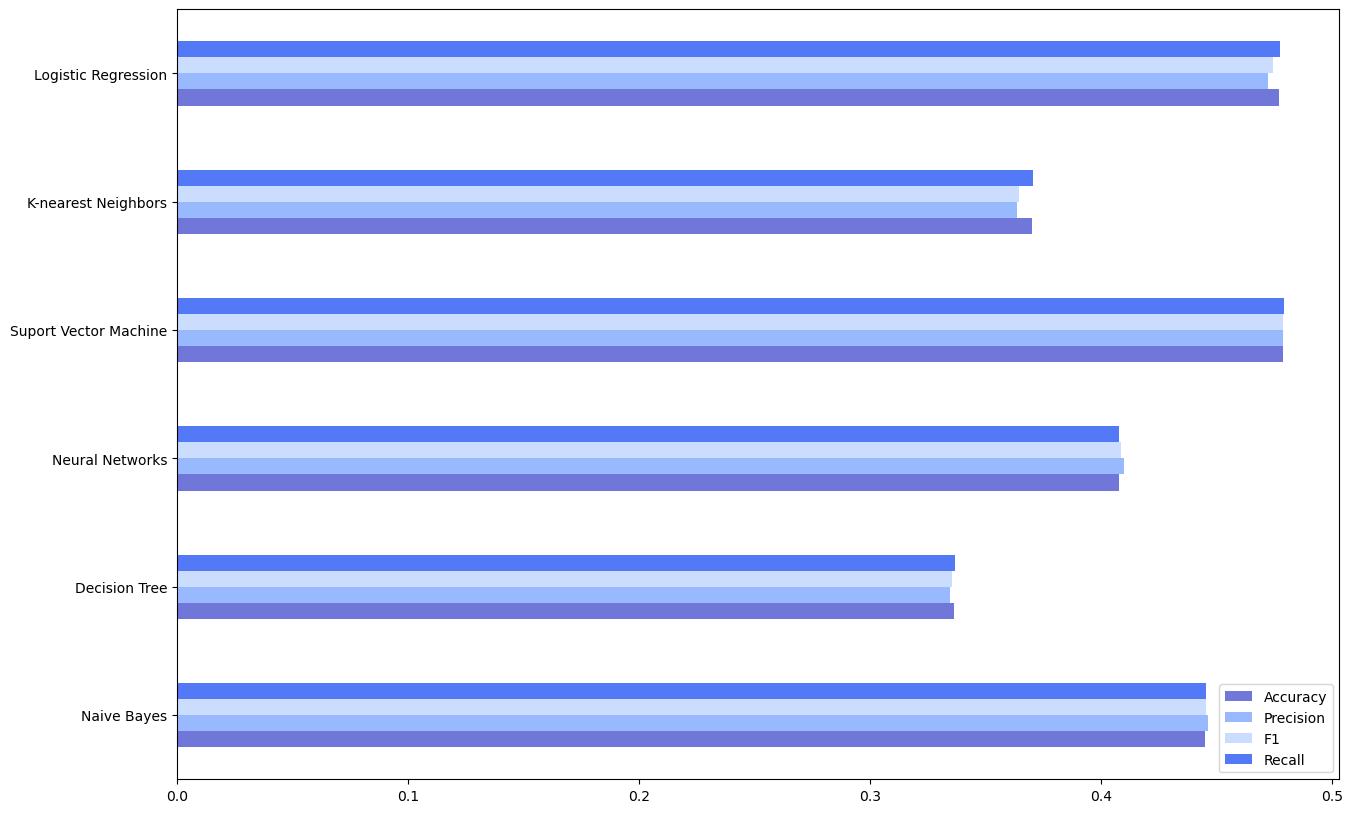

In [56]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams['font.size'] = '10'

data = {
  'Accuracy': accuracy,
  'Precision': precision,
  'F1': f1,
  'Recall': recall,
  }
df = pd.DataFrame(data, algorithms)
ax = df.plot.barh(color=['#7077D8','#99B9FF','#CADDFF','#5479F7'])
plt.show()


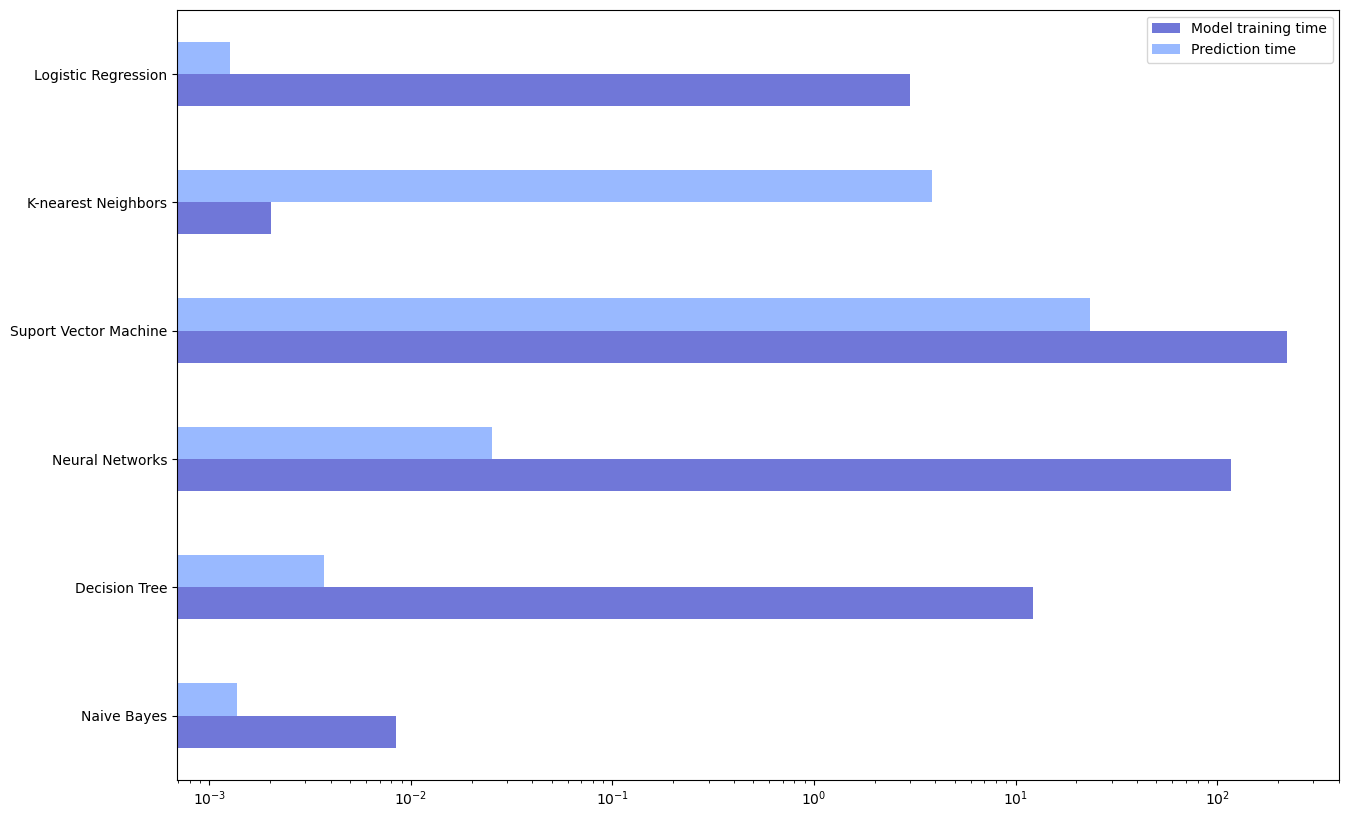

In [57]:
data = {
  'Model training time': times_fit,
  'Prediction time': times_predict,
  }
df = pd.DataFrame(data, algorithms)
ax = df.plot.barh(color=['#7077D8','#99B9FF'])
plt.xscale('log')

plt.show()

